In [1]:
import matplotlib.pyplot as plt
from joblib import load, dump
import pandas as pd
import numpy as np
import warnings, os

import seaborn as sns
import scipy.stats as stats
import tensorflow as tf

import aggmap
from aggmap import loadmap
from aggmap.show import imshow, imshow_wrap

warnings.filterwarnings("ignore")
sns.set(style= 'white',font_scale = 1.2)

In [2]:
from config import P

In [3]:
seed = P.seed #for the random permutation
metric = P.metric  # similarity measurement
var_thr = P.var_thr  # feature variance should larger than 0


color_list = P.color_list
mnist_labels_dict = P.mnist_labels_dict
data_save_folder = P.mnist_data_save_folder
results_save_folder = P.results_save_folder

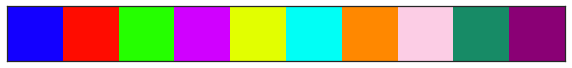

In [4]:
sns.palplot(color_list)

In [5]:
def tracked_orignal_change(orignal_image, new_mp):
    
    #mp = mp_ORSAggS4
    #orignal_image = trainX_OR1[0]
    df = new_mp._S.df.copy()
    SI = df.groupby('Subtypes').apply(lambda x:x.index.to_list())
    M, N, C = orignal_image.shape
    v = orignal_image.reshape(M*N*C, )
    arr_res = []
    for i, j in SI.items():
        j = [int(k.replace('p-',''))-1 for k in j]
        arr_1d = np.zeros(M*N, )
        arr_1d[j] = v[j]
        arr = arr_1d.reshape(M, N)  
        arr_res.append(arr)
    arr_tracked = np.stack(arr_res, axis=-1)
    return arr_tracked


In [6]:
if not os.path.exists(results_save_folder):
    os.makedirs(results_save_folder)

mp_train = loadmap(os.path.join(data_save_folder, 'train.mp'))
mp_test = loadmap(os.path.join(data_save_folder, 'test.mp'))


In [7]:
mp_train.info_distance.max()

1.4326772195765842

# 1. plot feature distances

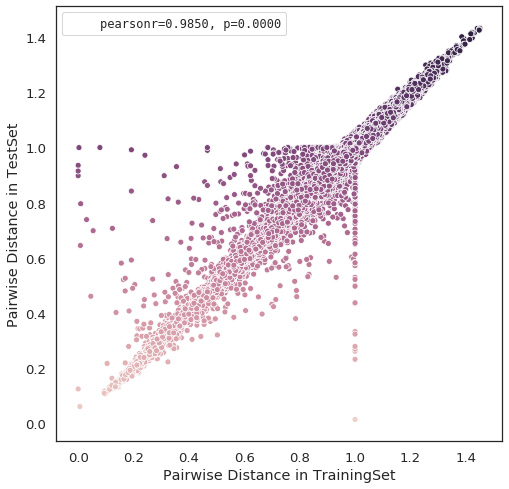

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

tr = 'Pairwise Distance in TrainingSet'
ts = 'Pairwise Distance in TestSet'

df = pd.DataFrame(mp_test.info_distance, index = mp_train.info_distance, 
                  columns = [tr])
df.index.name = ts
df = df.reset_index()
df = df[~((df[tr] == 0) | (df[ts] == 0))] 

r,p = stats.pearsonr(df[tr], df[ts])
annot_kws = {'prop':{'family':'monospace',  'size':12}}
#g = sns.jointplot(x=tr, y=ts, data=df, kind='reg') # Scatter and regression all green joint_kws={'color':'green'}
sns.scatterplot(x=tr, y=ts, data=df, ax=ax, hue = ts)

phantom, = ax.plot([], [], linestyle="", alpha=0)

ax.legend([phantom],['pearsonr=%.4f, p=%.4f' % (r,p)], **annot_kws)
# plt.yscale('log')
# plt.xscale('log')
plt.savefig(os.path.join(results_save_folder, '00_tr_ts_dist.png'), bbox_inches='tight', dpi=300)

# 2. plot feature types

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #(x_train, y_train), (x_test, y_test)


In [10]:
label_idxs = pd.Series(y_train).to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())

In [11]:
label_idxs

labels
0    [1, 21, 34, 37, 51, 56, 63, 68, 69, 75, 81, 88...
1    [3, 6, 8, 14, 23, 24, 40, 59, 67, 70, 72, 77, ...
2    [5, 16, 25, 28, 76, 82, 109, 117, 120, 122, 14...
3    [7, 10, 12, 27, 30, 44, 49, 50, 74, 86, 98, 10...
4    [2, 9, 20, 26, 53, 58, 60, 61, 64, 89, 92, 115...
5    [0, 11, 35, 47, 65, 100, 132, 138, 145, 173, 1...
6    [13, 18, 32, 36, 39, 62, 66, 73, 83, 90, 93, 1...
7    [15, 29, 38, 42, 52, 71, 79, 84, 91, 96, 101, ...
8    [17, 31, 41, 46, 55, 85, 94, 97, 125, 137, 144...
9    [4, 19, 22, 33, 43, 45, 48, 54, 57, 80, 87, 11...
dtype: object

In [12]:
X_OR1 = load(os.path.join(data_save_folder, '01_X_OR1.data'))
X_ORS1 = load(os.path.join(data_save_folder, '02_X_ORS1.data'))
X_ORSAgg1 = load(os.path.join(data_save_folder, '03_X_ORSAgg1.data'))
X_ORSAggC5 = load(os.path.join(data_save_folder, '04_X_ORSAggC5.data'))


In [13]:
mp_ORSAgg1 = loadmap(os.path.join(data_save_folder, 'mp_ORSAgg1.mp'))
mp_ORSAggC5 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC5.mp'))

### 2.1 plot feature maps for all classes

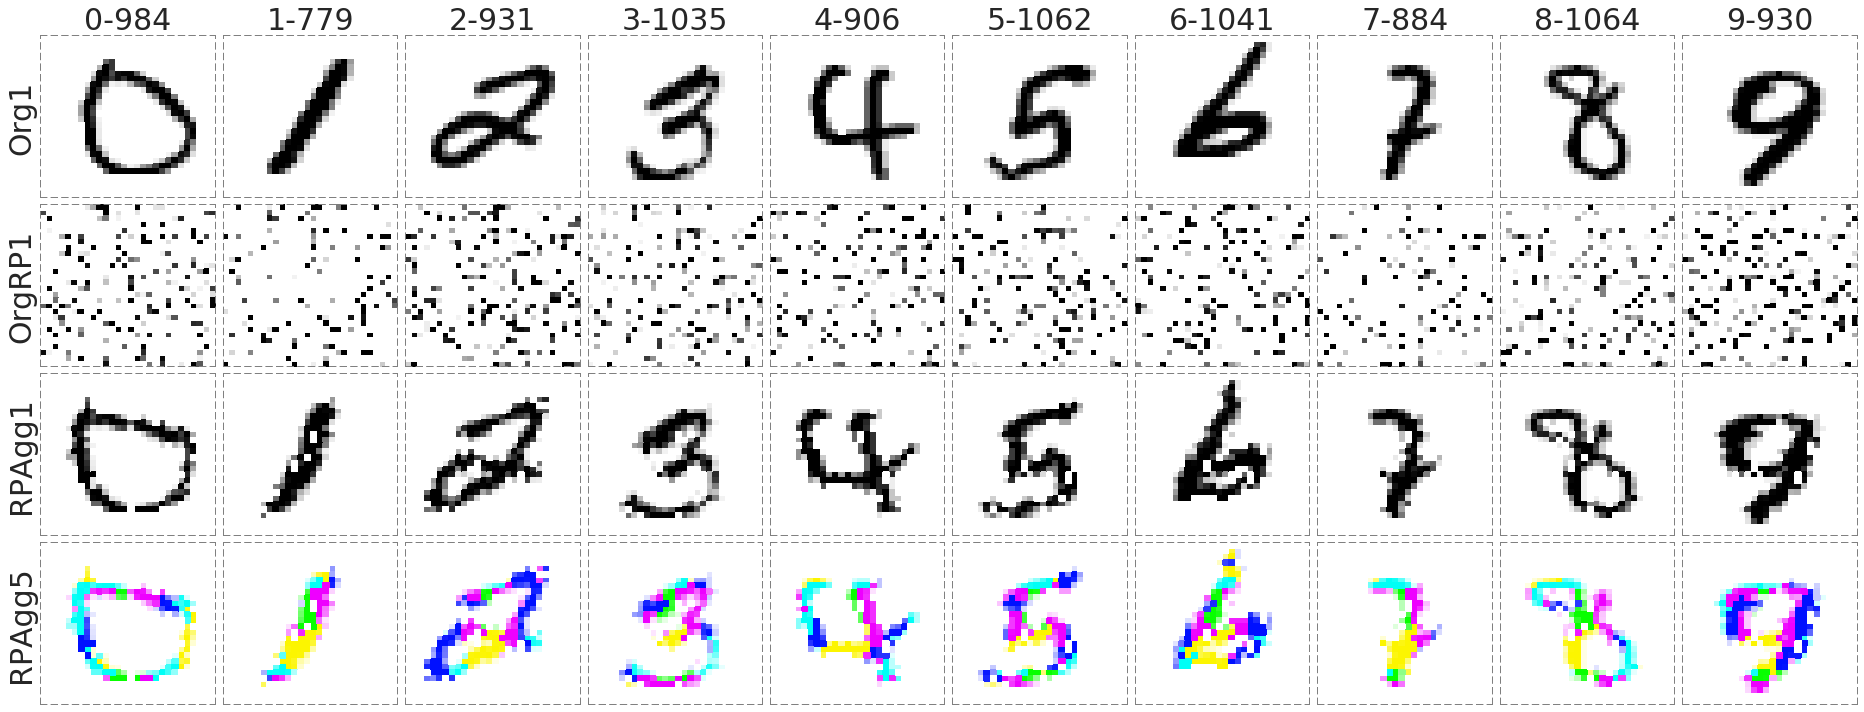

In [19]:
fmp_types = [X_OR1,  X_ORS1,  X_ORSAgg1, X_ORSAggC5] #, X_ORSAggC10
rows = ['Org1', 'OrgRP1', 'RPAgg1', 'RPAgg5'] #, 'RPAgg10'
cols = list(mnist_labels_dict.values())

image_idx = [pd.Series(label_idxs[i][:100]).sample(1, random_state = 88).to_list()[0] for i in range(len(label_idxs))]
cols = [i + '-%s' % j for i,j in zip(cols, image_idx)]

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(26,10), sharex = True, sharey = True)

fontsize = 30
## plot transformed images
for axc, X in zip(axes[:6], fmp_types):
    for ax, idx in zip(axc, image_idx):
        x = X[0][idx].astype(float)
        if x.shape[-1] == 1:
            imshow(x, ax=ax, color_list = ['black'], vmin = 0,  mode = 'light')
        else:
            imshow(x, ax=ax, color_list = pd.Series(mp_ORSAggC5.colormaps).tolist(), vmin = 0 , mode = 'light')
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': fontsize})
for ax, row in zip(axes[:6,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)    
    

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.04, hspace=0.04)
fig.savefig(os.path.join(results_save_folder, 'featuremaps_00_10_classes.png'), bbox_inches='tight', dpi=400) 

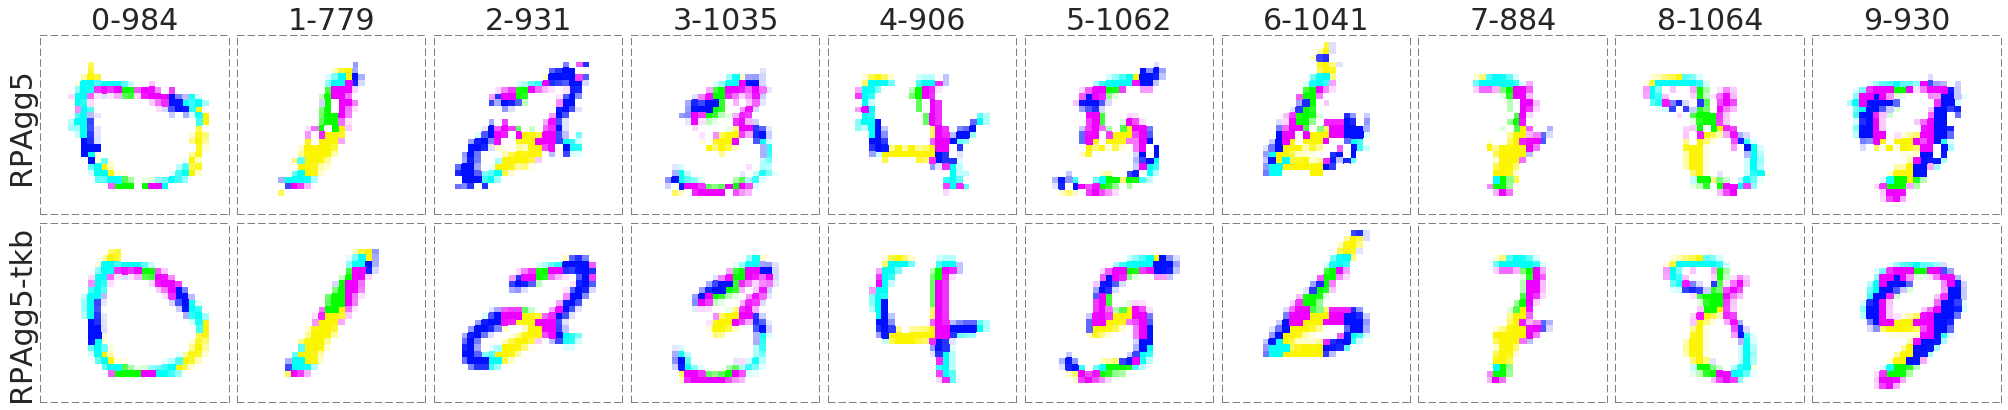

In [21]:
## plot tracked back images

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(28,6), sharex = True, sharey = True)

fmp_types = [X_ORSAggC5]
for axc, X in zip(axes[:1], fmp_types):
    for ax, idx in zip(axc, image_idx):
        x = X[0][idx].astype(float)
        if x.shape[-1] == 1:
            imshow(x, ax=ax, color_list = ['black'], vmin = 0, mode = 'light')
        else:
            imshow(x, ax=ax, color_list = pd.Series(mp_ORSAggC5.colormaps).tolist(), vmin = 0, mode = 'light')
            
for ax, row in zip(axes[:1,0], ['RPAgg5']):
    ax.set_ylabel(row, fontsize = fontsize) 
    
    
mps = [mp_ORSAggC5]
cols_name = ['RPAgg5-tkb']
for axc, mp in zip(axes[1:2], mps):
    for ax, idx in zip(axc, image_idx):
        x = tracked_orignal_change(X_OR1[0][idx], mp)
        imshow(x, ax=ax, color_list = pd.Series(mp_ORSAggC5.colormaps).tolist(), vmin = 0, mode = 'light')

for ax, row in zip(axes[1:2,0], cols_name):
    ax.set_ylabel(row, fontsize = fontsize)  
    
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': fontsize})

    
    
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.04, hspace=0.04)
fig.savefig(os.path.join(results_save_folder, 'featuremaps_01_tkb.png'), bbox_inches='tight', dpi=400) 

### 2.2 plot feature maps for each class

In [16]:
# rows = ['Org1', 'OrgRP1', 'RPAgg1', 'RPAgg3', 'RPAgg5']
# for label, label_name in mnist_labels_dict.items():
#     image_idx = pd.Series(label_idxs[label][:100]).sample(6, random_state = seed).tolist()
#     cols = [label_name + '-%s' % i for i in image_idx]
#     fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(22,20), sharex = True, sharey = True)
#     for axc, X in zip(axes, fmp_types):
#         for ax, idx in zip(axc, image_idx):
#             x = X[0][idx].astype(float)
#             imshow(x, ax=ax)
#     for ax, col in zip(axes[0], cols):
#         ax.set_title(col, fontdict = {'fontsize': fontsize})
#     for ax, row in zip(axes[:,0], rows):
#         ax.set_ylabel(row, fontsize = fontsize)    
#     fig.tight_layout()
#     fig.savefig(os.path.join(results_save_folder, 'featuremaps_01_%s.png' % str(label).zfill(2)), bbox_inches='tight', dpi=300)

### 2.2 plot feature map objects

In [17]:
mp_ORSAgg1.plot_grid(htmlpath = results_save_folder, htmlname = 'mp_ORSAgg1_grid.html')
mp_ORSAgg1.plot_scatter(htmlpath = results_save_folder, htmlname = 'mp_ORSAgg1_scatter.html', radius=5)

2020-10-18 14:18:17,768 - INFO - [bidd-aggmap] - generate file: ./results_data/mp_ORSAgg1_grid.html_feature points_717_correlation_umap_mp
2020-10-18 14:18:17,792 - INFO - [bidd-aggmap] - save html file to ./results_data/mp_ORSAgg1_grid.html_feature points_717_correlation_umap_mp
2020-10-18 14:18:17,793 - INFO - [bidd-aggmap] - generate file: ./results_data/mp_ORSAgg1_scatter.html_feature points_717_correlation_umap_scatter
2020-10-18 14:18:17,811 - INFO - [bidd-aggmap] - save html file to ./results_data/mp_ORSAgg1_scatter.html_feature points_717_correlation_umap_scatter


2020-10-18 14:18:17,825 - INFO - [bidd-aggmap] - generate file: ./results_data/mp_ORSAggC5_scatter.html_feature points_717_correlation_umap_scatter
2020-10-18 14:18:17,846 - INFO - [bidd-aggmap] - save html file to ./results_data/mp_ORSAggC5_scatter.html_feature points_717_correlation_umap_scatter
2020-10-18 14:18:17,847 - INFO - [bidd-aggmap] - generate file: ./results_data/mp_ORSAggC5_grid.html_feature points_717_correlation_umap_mp
2020-10-18 14:18:17,866 - INFO - [bidd-aggmap] - save html file to ./results_data/mp_ORSAggC5_grid.html_feature points_717_correlation_umap_mp


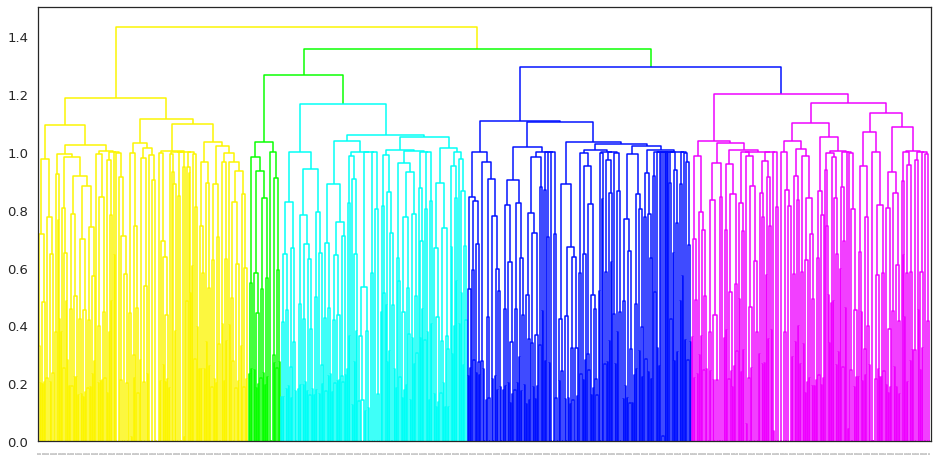

In [18]:
mp_ORSAggC5.plot_scatter(htmlpath = results_save_folder, htmlname = 'mp_ORSAggC5_scatter.html', radius=5 )
mp_ORSAggC5.plot_grid(htmlpath = results_save_folder, htmlname = 'mp_ORSAggC5_grid.html')
fig = mp_ORSAggC5.plot_tree(leaf_font_size = 1)
fig.savefig(os.path.join(results_save_folder, 'mp_ORSAggC5_tree.png'), bbox_inches='tight', dpi=300)